# A look at the statistics of the matched filter outputs

We have taken a *qualitative* tour of a digital communication system; we have discussed
* **constellations** for mapping bits to symbols
* **pulse shaping** for controlling the bandwidth of the signal
* **up and down conversion** for moving signals to desired frequency location:
  + baseband and passband signals
* **matched filter** for forming a properly weighted average of the received signal
* **slicer** for turning matched filter outputs into estimated bits

We are now embarking on a more *quantitative* analysis of the receiver. Goals of our analysis include:
* finding the structure of the best possible receiver, i.e., the receiver that achieves the smallest possible probability of error.
* computing the probability of error for a given system

To achieve this goal, we need to rely on statistical methods. In particular, we will need:
* Gaussian (normal) random variables
* Expected values, including mean and variance
* Conditional probabilities and Bayes theorem
* White Gaussian noise and its properties
* Filtering white Gaussian noise

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

In [2]:
# import functions from the `comms` package
# see prior notebooks for details
from comms.sources import string_source, string_sink
from comms.mod_mapping import BPSK, PAM4, mod_mapper, demodulator, plot_constellation
from comms.pulse_shaping import half_sine_pulse, sine_squared_pulse, pulse_shape

## Transmitting and Receiving a digitally modulated signal

We have simulated the transmission and reception of digitally modulated signals several times already. 

Our focus, this time, is on the output of the matched filter - especially, the statistical properties of the matched filter output.

Our system will use:
* BPSK modulation
* half-sine pulse shaping (this is not important today)
* half-sine matched filter; it only matters that this is the same as the pulse shaping
* we skip the up and down-conversion - it is not important today

In [3]:
## set signal parameters
T = 1
fs = 128
fsT = int(fs*T)

# modulation
mod_table = BPSK

# pulse shape p(t)
pp = half_sine_pulse(fsT)

# a fairly long string for transmission
msg_str = """In signal processing, the output of the matched filter is given by correlating a known
delayed signal, or template, with an unknown signal to detect the presence of the template in the
unknown signal. This is equivalent to convolving the unknown signal with a conjugated time-reversed
version of the template. The matched filter is the optimal linear filter for maximizing the
signal-to-noise ratio (SNR) in the presence of additive stochastic noise.
Matched filters are commonly used in radar, in which a known signal is sent out, and the reflected
signal is examined for common elements of the out-going signal. Pulse compression is an example of
matched filtering. It is so called because the impulse response is matched to input pulse signals.

Two-dimensional matched filters are commonly used in image processing, e.g., to improve the SNR of
X-ray observations.

Matched filtering is a demodulation technique with LTI (linear time invariant) filters to maximize
SNR. It was originally also known as a North filter."""

In [4]:
# make a signal
bits = string_source(msg_str)
syms = mod_mapper(bits, mod_table)
sig = pulse_shape(syms, pp, fsT)

# channel
n_pwr = fsT/10  # 10dB SNR
r_sig = sig + np.sqrt(n_pwr/fsT) * np.random.randn(len(sig))

# receiver
mf_out = np.real( np.convolve(r_sig, pp) )
rx_syms = mf_out[fsT::fsT]
rx_bits = demodulator(rx_syms, mod_table)

print('Received message:\n', string_sink(rx_bits))

Received message:
 In signal processing, the output of the matched filder is given by correlating a known
delayed signal, or template, with an unknown signal to detect the presence of the template in the
unknown signal. This is$equivalent to convolving the unknown signal with a conjugated time-reversed
version of the template. The matched filter is the optimal linmar filter for maximizing the
signal-to-noise ratio (SNR) in the presence of additive stochastic n�ise.
Matched filters are commonly used in radar, in which a known signal is sent out, and the reflected
signal is examined for common elements of the out-going signal. Pulse compression is an example of
matched filtering. It is so called because the impulse response is matched to input pulse signals.

Two-dimensional matched filters are commonly used in image processing, e.g., to improve the SNR of
X-ray observations.

Matched filtering is ` demodulation technique with LTI (linear time invariant) filters to maximize
SNR. It was o

### Focus on the matched filter output

It looks like the message is (largely) received correctly.

We would like to understand the receiver operation better; for that purpose, let's focus on the matched filter outputs.

Previously, we have looked at scatter plots of the matched filter outputs in relation to the transmitted symbols.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


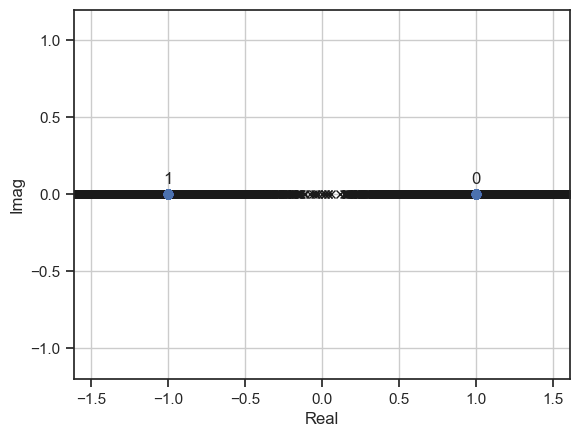

In [5]:
## scatter plot the matched filter outputs
plot_constellation(mod_table)

plt.plot(np.real(rx_syms), np.imag(rx_syms), 'kx')
plt.plot(np.real(syms), np.imag(syms), 'bo')

plt.show()

### Histogram of matched filter outputs

The scatter plot is not very helpful. There are too many symbols to discern any patterns.

Let's look at the *histogram* of the matched filter outputs instead.

* A histogram indicates how many observations fall into contiguous bins
* histograms approximate *probability density functions* (pdf)

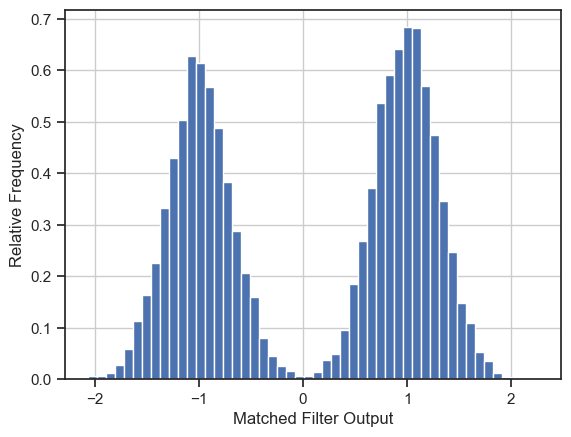

In [6]:
plt.hist(rx_syms, 50, density=True)
plt.grid()
plt.xlabel('Matched Filter Output')
plt.ylabel('Relative Frequency')

plt.show()

#### Interpreting the histogram

This is a much more useful plot. We recognize:

* most matched filter outputs cluster near $+1$ and $-1$; i.e., the symbols of the BPSK constellation
* the spread around these two clusers appears to be similar
* the height of the two peaks is rougly the same
  - slightly more obsservations near $+1$

**Hypothesis:** 
* transmitted $+1$ symbols cause the cluster on the right 
* transmitted $-1$ symbols cause the cluster on the left

**Experiment:** Divide the matched filter outputs into two classes:
1. matched filter outputs when $+1$ symbol was sent ($0$ bits)
2. matched filter outputs when $-1$ symbol was sent ($1$ bits)

Plot separate histograms for the two classes.

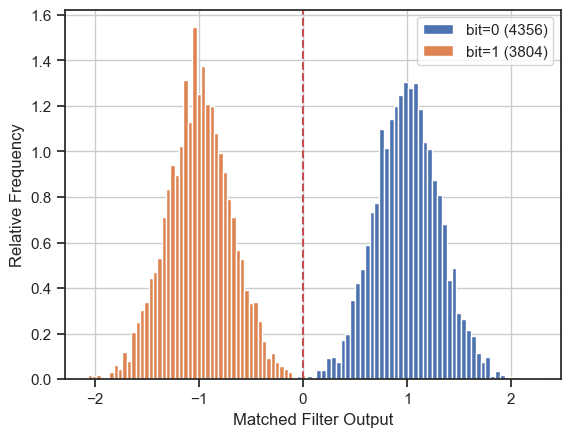

In [7]:
# divide the matched filter outputs; easy with logical indexing
rx_0_syms = rx_syms[bits==0]
rx_1_syms = rx_syms[bits==1]

# plot two histograms
plt.hist(rx_0_syms, 50, density=True, label=f'bit=0 ({len(rx_0_syms)})')
plt.hist(rx_1_syms, 50, density=True, label=f'bit=1 ({len(rx_1_syms)})')

plt.grid()
plt.xlabel('Matched Filter Output')
plt.ylabel('Relative Frequency')
plt.axvline(0, color='r', ls='--')
plt.legend()

plt.show()

### Conditional distributions

The histograms show that:
* the matched filter outputs corresponding to transmitted 0 bits cluster around $+1$
* the matched filter outputs corresponding to transmitted 1 bits cluster around $-1$
* the two histograms have similar shape, including height and spread
* the two distributions are separable; there is very little overlap
  + the diving line is at output $0$ (red line)

The two histograms approximate the *conditional probability density functions* of the matched filter output:
* conditioned on the assumption that a 0-bit was sent, a probability density approximated by the blue histogram results
* conditioned on the assumption that a 1-bit was sent, a probability density approximated by the orange histogram results

We will show, that the conditional pdfs are Gaussian:
* with different means; +1 and -1, respectively
* identical variances; here $\sigma^2 = 0.1$

The plot below shows the two conditional Gaussian pdfs; they match the histograms very well.

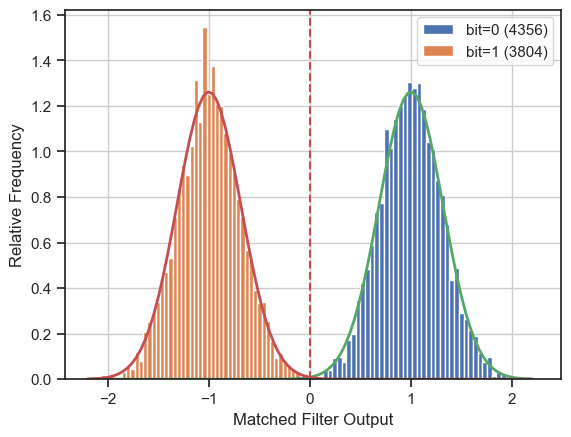

In [8]:
from scipy.stats import norm
rv0 = norm(loc=1, scale=np.sqrt(0.1))
rv1 = norm(loc=-1, scale=np.sqrt(0.1))
x = np.linspace(-2.2, 2.2, 101)

# plot two histograms
plt.hist(rx_0_syms, 50, density=True, label=f'bit=0 ({len(rx_0_syms)})')
plt.hist(rx_1_syms, 50, density=True, label=f'bit=1 ({len(rx_1_syms)})')

plt.plot(x, rv0.pdf(x), lw=2)
plt.plot(x, rv1.pdf(x), lw=2)

plt.grid()
plt.xlabel('Matched Filter Output')
plt.ylabel('Relative Frequency')
plt.axvline(0, color='r', ls='--')
plt.legend()

plt.show()

## Questions

The conditional pdfs from a statistical model for the output of the matched filter; for each possibly transmitted bit, $b=0$ or $b=1$, the matched filter output $R$ is *conditionally* Gaussian distributed. The mean of the Gaussian distribution depends on which bit was transmitted; the variance is independent of the transmitted bit - it depends only on the noise

1. **Decision rule:** Given this model and an observed matched filter output $R$, how should we decide if $b=0$ or $b=1$ was transmitted? I.e., we are looking for a mapping from observed matched filter outputs $R$ to bit decisions $\hat{b} \in \{0,1\}$.
2. **Error probability:** What is the probability that the decision rule leads to a wrong decision, $b \neq \hat{b}$?